In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from hlpr_func import lat_mean, sindeg, calc_trend_HAC, get_weights_values, linreg_weighted

In [2]:
# open ERA5-CAMS reanalysis
ds = xr.open_dataset("ERA5-CAMS/era5-interpolated.nc")
ds["q800"] = ds.sel(pressure_level=800).q *1e3
ds["rh800"] = ds.sel(pressure_level=800).r
ds = ds.drop_vars(["r","t","q","pressure_level"])
ds

<xarray.Dataset> Size: 3GB
Dimensions:   (time: 289, lat: 180, lon: 360)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-03-15 2000-04-15 ... 2024-03-15
  * lat       (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables: (12/19)
    u10       (time, lat, lon) float64 150MB ...
    v10       (time, lat, lon) float64 150MB ...
    sst       (time, lat, lon) float64 150MB ...
    sp        (time, lat, lon) float64 150MB ...
    si10      (time, lat, lon) float64 150MB ...
    i10fg     (time, lat, lon) float64 150MB ...
    ...        ...
    lsmask    (time, lat, lon) float64 150MB ...
    landmask  (time, lat, lon) float64 150MB ...
    icemask   (time, lat, lon) int64 150MB ...
    limask    (time, lat, lon) float64 150MB ...
    q800      (time, lat, lon) float64 150MB 0.04603 0.04603 ... 0.4696 0.4701
    rh800     (time, lat, lon) float64 150MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-21 19:40:22 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [11]:
# add extra coord
da = ds.assign_coords({"month_since_start": ("time", np.arange(len(ds.time.values)))})

# select only DJF
djf = da.where(ds.time.dt.month.isin([12,1,2]))

# remove austrailian bush fires (Dec 2019 - Mar 2020)
djf = djf.where(~(djf.time.dt.year.isin(2019) & djf.time.dt.month.isin(12)))
djf = djf.where(~(djf.time.dt.year.isin(2020) & djf.time.dt.month.isin([1,2])))
djf = djf.where(~(djf.time.dt.year.isin(2014) & djf.time.dt.month.isin([12])))

# add weights
weights = djf.time.dt.days_in_month
weights = weights.where(weights.time.dt.month!=2, 28.65)
djf["days_in_month"] = weights

# calculate climatology and remove seasons
climatology = djf.groupby("time.month").mean("time")
deseasonalized = djf.groupby("time.month") - climatology + climatology.weighted(climatology.days_in_month).mean("month")

# take regional mean over Southern Ocean
so = lat_mean(deseasonalized.sel(lat=slice(-75,-45)).where(deseasonalized.landmask==0).mean("lon"))
so["days_in_month"] = weights

# swap time to monotonic index
da = so.swap_dims({"time":"month_since_start"})
print(da)

# calculate linear trend
polyfit_result = da.polyfit("month_since_start", 1, skipna=True, w=da.days_in_month)
so_linear = da.month_since_start * polyfit_result.sel(degree=1) + polyfit_result.sel(degree=0)
for v in so_linear.keys():
    so_linear = so_linear.rename_vars({v:v.split("_polyfit")[0]})
so_linear = so_linear.swap_dims({"month_since_start":"time"})

# remove linear trend
so_detrended = so - so_linear

# save trend separately
trend = polyfit_result.sel(degree=1) * 120 # per decade
for v in trend.keys():
    trend = trend.rename_vars({v:v.split("_polyfit")[0]})

<xarray.Dataset> Size: 53kB
Dimensions:            (month_since_start: 289)
Coordinates:
    time               (month_since_start) datetime64[ns] 2kB 2000-03-15 ... ...
  * month_since_start  (month_since_start) int64 2kB 0 1 2 3 ... 285 286 287 288
    month              (month_since_start) int64 2kB 3 4 5 6 7 8 ... 11 12 1 2 3
Data variables: (12/20)
    u10                (month_since_start) float64 2kB nan nan nan ... 4.826 nan
    v10                (month_since_start) float64 2kB nan nan ... -0.8258 nan
    sst                (month_since_start) float64 2kB nan nan nan ... 277.1 nan
    sp                 (month_since_start) float64 2kB nan nan ... 9.935e+04 nan
    si10               (month_since_start) float64 2kB nan nan nan ... 8.916 nan
    i10fg              (month_since_start) float64 2kB nan nan nan ... 11.69 nan
    ...                 ...
    landmask           (month_since_start) float64 2kB nan nan nan ... 0.0 nan
    icemask            (month_since_start) float64 2k

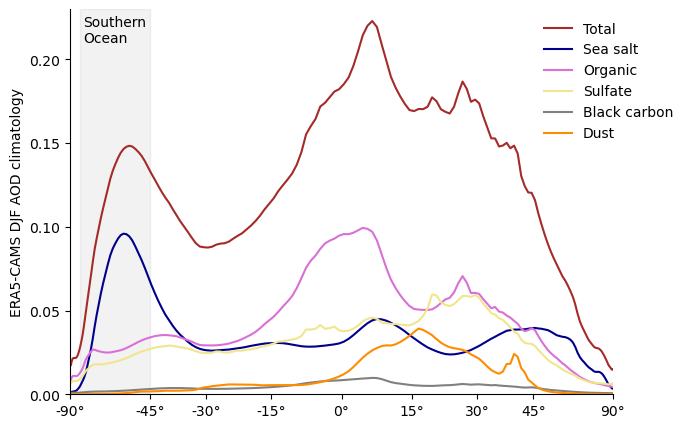

In [12]:
zm = climatology.weighted(climatology.days_in_month).mean("month").mean("lon")

fig,ax = plt.subplots(figsize=(7,5))

x = sindeg(zm.lat)
ax.plot(x, zm.aod550, label="Total", color="brown")
ax.plot(x, zm.ssaod550, label="Sea salt", color="darkblue")
ax.plot(x, zm.omaod550, label="Organic", color="orchid")
ax.plot(x, zm.suaod550, label="Sulfate", color="khaki")
ax.plot(x, zm.bcaod550, label="Black carbon", color="grey")
ax.plot(x, zm.duaod550, label="Dust", color="darkorange")

ax.legend(frameon=False, bbox_to_anchor=(0.85,1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel("ERA5-CAMS DJF AOD climatology")
ax.set_ylim(0,0.23)

xticks = [-90, -45, -30, -15, 0, 15, 30, 45, 90]
ax.set_xticks(sindeg(xticks),[str(xt)+"°" for xt in xticks])
ax.set_xlim(-1,1)

ax.axvspan(sindeg(-75), sindeg(-45), color="grey", alpha=0.1)
ax.text(sindeg(-72), 0.21, "Southern\nOcean")

plt.savefig("talk-figures/era-cams-aod.png", dpi=200, facecolor="w", bbox_inches="tight")
plt.show()

In [13]:
# fig,axes = plt.subplots(1,3,figsize=(10,3),constrained_layout=True)

# axes[0].plot(so_detrended.si10, so_detrended.sst, "o")
# axes[0].set_xlabel("si10")
# axes[0].set_ylabel("sst")

# axes[1].plot(so_detrended.si10, so_detrended.ssaod550, "o")
# axes[1].set_xlabel("si10")
# axes[1].set_ylabel("ssaod550")

# axes[2].plot(so_detrended.sst, so_detrended.ssaod550, "o")
# axes[2].set_xlabel("sst")
# axes[2].set_ylabel("ssaod550")
# plt.show()

# from sklearn.linear_model import LinearRegression

# clean = so_detrended[["si10","sst","ssaod550"]].dropna("time")
# X = np.array([clean.si10.values, clean.sst.values]).T
# y = clean.ssaod550.values
# model = LinearRegression()
# model.fit(X, y)

# print(model.coef_)
# print(model.intercept_)
# print(model.coef_[0]*trend["si10"].values + model.coef_[1]*trend["sst"].values)
# print(trend["ssaod550"].values)

In [14]:
nicename = {
    "F_TOA": "$F^\\uparrow_{TOA}$",
    "F_surf": "$F_{surf}$",
    "F_clr": "$F_{clr}$",
    "F_cloud": "$F_{cloud}$",
    "aod": "AOD",
    "ssaod550": "Sea salt AOD",
    "si10": "Wind speed",
    "sst": "SST",
    "rh800": "RH$_{800}$",
    "suaod550": "Sulfate AOD",
    "omaod550": "Organic AOD",
    "aod550": "Total AOD",
}

plotcolor = {
    "F_TOA": "black",
    "F_surf": "mediumseagreen",
    "F_clr": "hotpink",
    "F_cloud": "deepskyblue",
    "aod": "brown",
    "ssaod550": "darkblue",
    "si10": "black",
    "sst": "black",
    "rh800": "black",
    "suaod550": "khaki",
    "omaod550": "orchid",
    "aod550": "brown",
}

units = {
    "F_TOA":"W m$^{-2}$",
    "F_surf":"W m$^{-2}$",
    "F_clr":"W m$^{-2}$",
    "F_cloud":"W m$^{-2}$",
    "aod":"-",
    "ssaod550":"-",
    "si10":"m s$^{-1}$",
    "sst":"K",
    "rh800":"%",
    "suaod550":"-",
    "omaod550":"-",
    "aod550":"-",
}

a1 = slope(ssaod550 vs. si10) = 0.0149
actual si10 trend = 0.2183
actual ssaod550 trend = 0.0035
predicted ssaod550 trend = 0.0033

a1 = slope(ssaod550 vs. sst) = -0.0175
actual sst trend = 0.0798
actual ssaod550 trend = 0.0035
predicted ssaod550 trend = -0.0014

a1 = slope(ssaod550 vs. rh800) = -0.0018
actual rh800 trend = 0.0134
actual ssaod550 trend = 0.0035
predicted ssaod550 trend = -0.0000

a1 = slope(suaod550 vs. si10) = 0.0020
actual si10 trend = 0.2183
actual suaod550 trend = 0.0011
predicted suaod550 trend = 0.0004

a1 = slope(suaod550 vs. sst) = 0.0026
actual sst trend = 0.0798
actual suaod550 trend = 0.0011
predicted suaod550 trend = 0.0002

a1 = slope(suaod550 vs. rh800) = -0.0001
actual rh800 trend = 0.0134
actual suaod550 trend = 0.0011
predicted suaod550 trend = -0.0000

a1 = slope(omaod550 vs. si10) = 0.0035
actual si10 trend = 0.2183
actual omaod550 trend = 0.0050
predicted omaod550 trend = 0.0008

a1 = slope(omaod550 vs. sst) = -0.0077
actual sst trend = 0.0798
actua

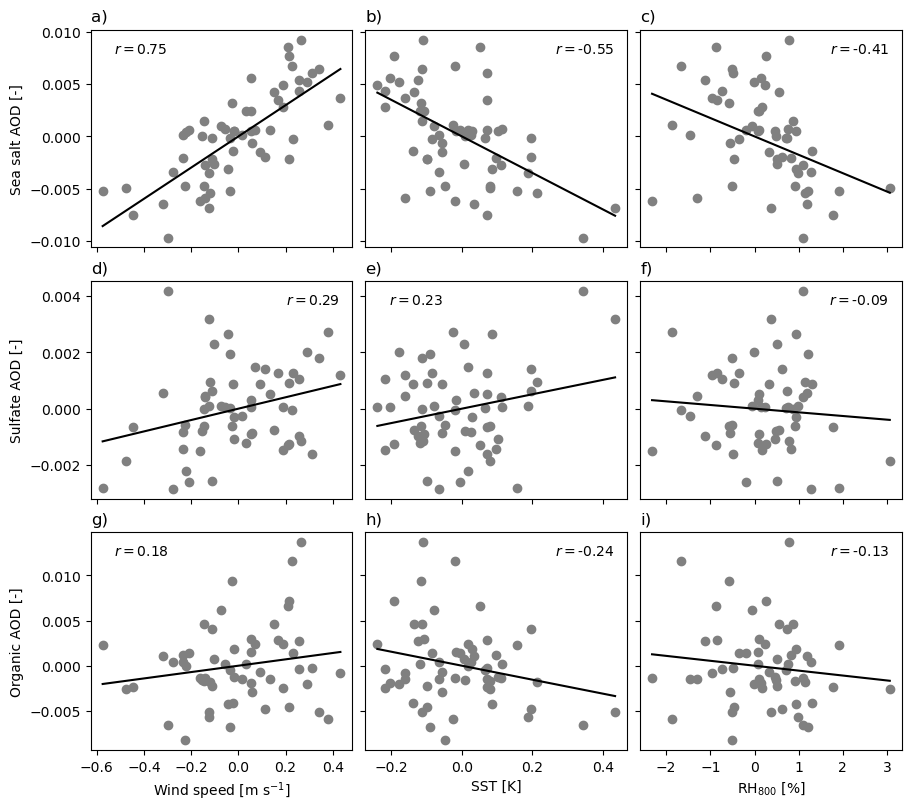

In [15]:
fig, axes = plt.subplots(3,3, figsize=(9,8), constrained_layout=True, sharex="col", sharey="row")

yvar = ["ssaod550", "ssaod550", "ssaod550", "suaod550", "suaod550", "suaod550", "omaod550", "omaod550", "omaod550"]
xvar = ["si10", "sst", "rh800", "si10", "sst", "rh800", "si10", "sst", "rh800"]

for i,var in enumerate(xvar):
    ax = axes.flatten()[i]

    if var == "skip":
        ax.remove()
        continue

    ax.plot(so_detrended[xvar[i]], so_detrended[yvar[i]], marker="o", lw=0, color="grey")
    if i > 5:
        ax.set_xlabel(nicename[xvar[i]]+" ["+units[xvar[i]]+"]")
    if i % 3 == 0:
        ax.set_ylabel(nicename[yvar[i]]+" ["+units[yvar[i]]+"]")

    xval, yval = so_detrended[xvar[i]].values, so_detrended[yvar[i]].values
    ww = (~np.isnan(xval) & ~np.isnan(yval))
    idx = np.argsort(xval[ww])
    xsort, ysort = xval[ww][idx], yval[ww][idx]
    weights = get_weights_values(so_detrended[xvar])[ww][idx]
    result = linreg_weighted(xsort, ysort, weights)
    ax.plot(xsort, xsort*result["slope"], color="k", 
            label="$r = ${:.2f}".format(result["rvalue"]))
    ax.legend(loc="best", frameon=False, handlelength=0)
    letter = ["a)","b)","c)","d)","e)","f)","g)","h)","i)"]
    ax.set_title(letter[i], loc="left")

    a1 = result["slope"]
    print(f"a1 = slope({yvar[i]} vs. {xvar[i]}) = {a1:.4f}")
    print(f"actual {xvar[i]} trend = {trend[xvar[i]].values:.4f}")
    print(f"actual {yvar[i]} trend = {trend[yvar[i]].values:.4f}")
    print(f"predicted {yvar[i]} trend = {a1 * trend[xvar[i]].values:.4f}")
    print()

print("DJF (w/o '19-'20), Southern Ocean (45-75°S, ocean only), Detrended & deseasonalized anomalies")
plt.savefig("paper-figures/era5-scatter-aod-controlling-factors.png",dpi=200,facecolor="w",bbox_inches="tight")
plt.show()

In [8]:
# calculate linear trend on whole SO region
da = deseasonalized.sel(time=slice("2003","2023"))
da = da.assign_coords({"month_since_2003-01": ("time", np.arange(len(da.time.values)))})
da = da.swap_dims({"time":"month_since_2003-01"})
fit = da.polyfit("month_since_2003-01", 1, w=da.days_in_month)
da.close()

fit

<xarray.Dataset> Size: 20MB
Dimensions:                             (degree: 2, lat: 180, lon: 360)
Coordinates:
  * degree                              (degree) int64 16B 1 0
  * lat                                 (lat) float32 720B -89.5 -88.5 ... 89.5
  * lon                                 (lon) float32 1kB 0.5 1.5 ... 359.5
Data variables: (12/20)
    u10_polyfit_coefficients            (degree, lat, lon) float64 1MB 0.0027...
    v10_polyfit_coefficients            (degree, lat, lon) float64 1MB -0.000...
    sst_polyfit_coefficients            (degree, lat, lon) float64 1MB nan .....
    sp_polyfit_coefficients             (degree, lat, lon) float64 1MB -2.691...
    si10_polyfit_coefficients           (degree, lat, lon) float64 1MB 2.796e...
    i10fg_polyfit_coefficients          (degree, lat, lon) float64 1MB -8.573...
    ...                                  ...
    landmask_polyfit_coefficients       (degree, lat, lon) float64 1MB -1.733...
    icemask_polyfit_coefficients        (degree, lat, lon) float64 1MB 0.0 .....
    limask_polyfit_coefficients         (degree, lat, lon) float64 1MB -1.733...
    q800_polyfit_coefficients           (degree, lat, lon) float64 1MB 0.0001...
    rh800_polyfit_coefficients          (degree, lat, lon) float64 1MB 0.0066...
    days_in_month_polyfit_coefficients  (degree) float64 16B -1.295e-17 30.49

DJF (w/o '19-'20), Southern Ocean (45-75°S, Ocean only)


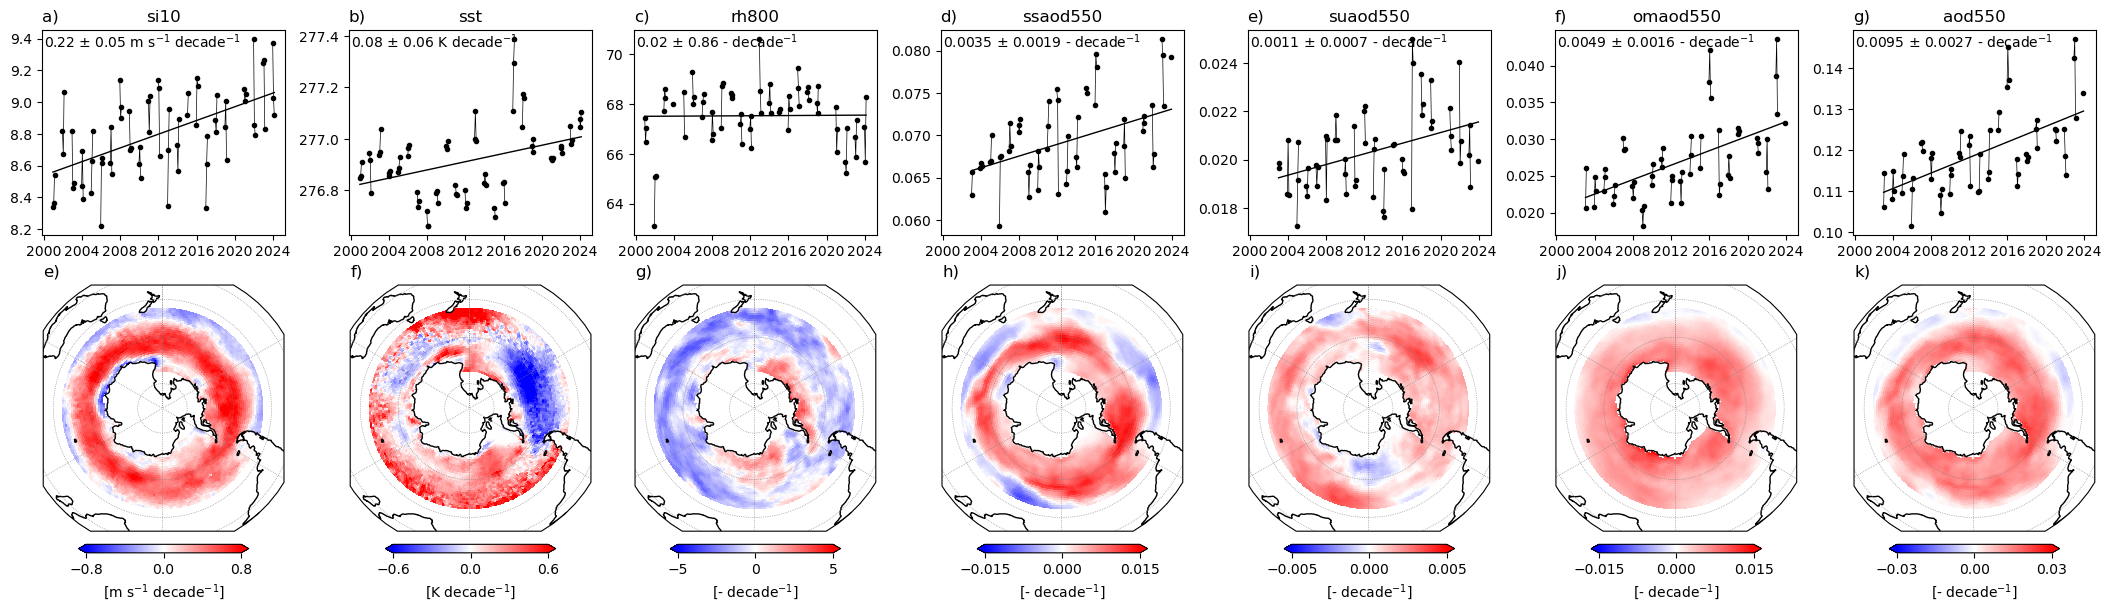

In [9]:
units = {"F_TOA":"W m$^{-2}$",
         "F_surf":"W m$^{-2}$",
         "F_clr":"W m$^{-2}$",
         "F_cloud":"W m$^{-2}$",
         "aod":"-",
         "ssaod550":"-",
         "suaod550":"-",
         "omaod550":"-",
         "aod550":"-",
         "si10":"m s$^{-1}$",
         "sst":"K",
         "q800":"g/kg",
         "rh800":"-",}

print("DJF (w/o '19-'20), Southern Ocean (45-75°S, Ocean only)")

fig = plt.figure(figsize=(21,6), constrained_layout=True)
gs = fig.add_gridspec(ncols=7, nrows=2, height_ratios=[1, 1.2])
crange = {"si10":0.8, "sst":0.6, "suaod550":0.005, "ssaod550":0.015, "omaod550":0.015, "aod550":0.03, "q800":0.2, "rh800":5}

letter = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)", "k)", "l)", "m)", "n)"]
for i,var in enumerate(["si10", "sst", "rh800", "ssaod550", "suaod550", "omaod550", "aod550"]):
    ax = fig.add_subplot(gs[0,i])
    if i == 0:
        ax1 = ax
    else:
        ax.sharex(ax1)

    y = so[var].dropna(dim="time")
    t = y.month_since_start.values
    w = get_weights_values(y)
    fitted, trend, trend_pm = calc_trend_HAC(t, y.values, w, hac_maxlags=12)

    ax.plot(y.time, fitted, color="k", lw=1)
    ax.plot(so.time, so[var], ".-", color="k", lw=0.5)
    
    if var == "si10" or var == "sst" or var == "q800" or var == "rh800":
        ax.text(0.01, 0.99, f"{trend*120:.2f} $\\pm$ {trend_pm*120:.2f}"+" "+units[var]+" decade$^{-1}$", ha='left', va='top', transform=ax.transAxes, fontsize=10)
    else:
        ax.text(0.01, 0.99, f"{trend*120:.4f} $\\pm$ {trend_pm*120:.4f}"+" "+units[var]+" decade$^{-1}$", ha='left', va='top', transform=ax.transAxes, fontsize=10)
    ax.set_title(var)
    ax.set_title(letter[i], loc="left")

    ####
    ax = fig.add_subplot(gs[1,i], projection=ccrs.Orthographic(180, -90))
    ax.set_extent([-180, 180, -90, -30], crs=ccrs.PlateCarree())
    ax.set_aspect('equal', 'box')
    
    trend = fit.sel(degree=1)[var+"_polyfit_coefficients"] * 120 # convert from per month to per decade
    trend = trend.where(ds.landmask.mean("time") == 0).where((ds.lat < -45) & (ds.lat > -75))

    cf = ax.pcolormesh(ds.lon, ds.lat, trend, vmin=-crange[var], vmax=crange[var],
                cmap="bwr", transform=ccrs.PlateCarree())

    ax.coastlines()
    ax.set_title(letter[i+4], loc="left")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='gray', linestyle=':')
    plt.colorbar(cf, extend="both", label="["+units[var]+" decade$^{-1}$]",
                 orientation='horizontal', shrink=0.7, ticks = np.linspace(-crange[var],crange[var],3))

plt.savefig("figures/era5-trends-aod-controlling-factors.png",dpi=200,facecolor="w",bbox_inches="tight")
plt.show()